# Лабораторная работа 4. 

## Задание

В данном задании мы будем работать с подмножеством датасета IMDB Movies Reviews из соревнования [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data). 
![](http://i.imgur.com/QZgxFic.png)

Задача состоит в следующем: по отзыву на фильм необходимо понять является ли он положительным или отрицательным. Это один из примеров задачи анализа тональности текста ([sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis)). Пример отзыва из выборки:
    
    This can be one of the most enjoyable movies ever if you don't take it seriously. It is a bit dated and the effects are lame, but it is so enjoyable. There are giant crabs that attack a girl. oh, and the crabs sing Japanese. It is amazingly bad. And the ending, which has been telegraphed throughout the entire film is hideously awesome. Predictable, but seeing the final fight will leave you rolling in your seat. Don't even give this film a chance and you will love it. Susan George is fun to watch and yes, she does appear naked. Her daughter isn't quite worth putting up with, but she does get attacked by giant crabs. They are the size of large cats. This is a 2, but I love it. As a movie, my God, but for entertainment, I give it a 7. Did I mention there are giant crabs?

Загрузите датасет из файла *data.tsv*.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from scipy.stats import randint as sp_rand
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [2]:
data = pd.read_table("data/labeledTrainData.tsv")

In [3]:
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [4]:
y = data['sentiment']
data.drop(['sentiment'],inplace=True,axis = 1)

In [5]:
data.head()

,id,review
0,5814_8,With all this stuff going down at the moment w...
1,2381_9,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,The film starts with a manager (Nicholas Bell)...
3,3630_4,It must be assumed that those who praised this...
4,9495_8,Superbly trashy and wondrously unpretentious 8...


In [6]:
y.mean()

0.5

Для оценки качества в данной задаче мы будем использовать отложенную выборку. Разделите все данные на две части: 16000 объектов будет обучающей выборкой и 4000 объектов — тестовой.

Вам будет необходимо учесть следующие особенности разбиения:
 - оно должно быть воспроизводимо
 - соотношение классов в каждой из частей должно сохраняться (например, при использовании функции *train_test_split* указать *stratify*)

In [137]:
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
Xtr.shape,Xval.shape

((16000,), (9000,))

In [20]:
Xtr.head()

10491    Need I say--its a stinker! (I gave it a rating...
22763    I had hoped this movie was going to be mildly ...
5505     This has got to be the cheesiest, stupidest, m...
24018    All of those who voted less than 5 are obvious...
20404    Does anyone know what kind of pickup John T dr...
Name: review, dtype: object

Одна из сложностей данной задачи — текстовое представление данных, так как не существует какого-то универсального способа извлечения признаков из текстов. По ходу работы мы получим несколько наборов признаков, которые будем сравнивать между собой.

Для начала попробуем самый простой подход, а именно [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) кодирование данных. С помощью него каждый текст будет представлен в виде вектора, размер которого равен размеру словаря, а на каждой позиции стоит число, сколько раз соответствующее слово встретилось в этом тексте. Кроме того, хорошей практикой является отфильтровывать стоп-слова.

Это представление можно получить используя класс [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) из библиотеки sklearn. Одно из удобств данного метода состоит в том, что возвращаемый результат является [sparse](http://docs.scipy.org/doc/scipy-0.15.1/reference/sparse.html)-матрицей, так как при таком преобразовании получается достаточно много 0. Более подробно про такие матрицы можно прочитать, например, [здесь](http://www.scipy-lectures.org/advanced/scipy_sparse/index.html).

Примените *bag-of-words* кодирование данных. Мы рекомендуем обучать здесь и в дальнейшем преобразование на обучающей выборке, после чего применять его к тестовой. Какой размерности стали данные?

In [127]:
cv = CountVectorizer(stop_words = 'english')
cv.fit(Xtr)
print(len(cv.vocabulary_))

62253


In [128]:
Xtr = cv.transform(Xtr)
Xval = cv.transform(Xval)
Xtr.shape,Xval.shape

((16000, 62253), (9000, 62253))

После того как было получено некоторое подходящее представление данных, хочется обучить алгоритмы классификации и сравнить их между собой. Для этого необходимо понять по каким метрикам будут сравниваться алгоритмы. Для начала можно рассмотреть, например, следующе метрики:

- accuracy: $$ Accuracy = \frac{1}{l}\sum_{i=1}^l[y_i = \hat{y}_i]$$ где $y_i$ — истинный ответ на объекте $x_i$, $\hat{y}_i$ — предсказанный. (мы не рекомендуем переводить *accuracy* как точность, потому что в русскоязычной литературе точностью называют другую метрику)
- точность: $$Precision = \frac{TP}{TP + FP}$$
- полнота: $$Recall = \frac{TP}{TP + FN}$$

где обозначения *TP*, *FP*, *FN* и *TN* — элементы матрицы ошибок:

| | y = 1 | y = 0 |
|------|------|
|   a(x) = 1  | TP| FP |
| a(x) = 0| FN | TN |

Обратите внимание, что точность и полнота вычисляются относительно фиксированного класса. В sklearn есть удобная функция [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), позволяющая сразу вычислять эти метрики для всех классов. 

**(1 балл) Задание 1.**

Какие недостатки для данной задачи вы видите у метрики *Accuracy*?

Обучите логистическую регрессию и случайный лес с 500 деревьев на *bag-of-words* представлении выборки и измерьте качество на тестовых данных с помощью трех описанных выше метрик. Кроме этого, сравните время обучения алгоритмов. Есть ли существенная разница в качестве алгоритмов? Какой из методов кажется менее применимым в данной задаче и почему?

Недостатки возможно связаны с тем, что нам важнее предсказывать именное плохие фильмы, потому что посоветовав человеку ошибочно лохой фильм, он может больше не воспользоваться услугами сайта. А если мы случайно не порекомендуем ему хороший фильм, то ничего страшного, скорее всего он о нем все равно услушит. Поэтому возможно метрика Recall более полезна для этой задачи. Если бы у нас были несбалансированные классы, тогда метрика Accuracy была плоха тем, что если например у нас 90% единичек, то классификатор просто обучится всегда предсказывать 1 и не будет ничему полезному учиться и не сможет ничего полезного предсказать. Но в нашем случае классы сбалансированы!

In [124]:
y.mean()

0.5

In [130]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(Xtr, ytr)
target_names = ['class 0', 'class 1']
print("TRAIN")
print(classification_report(ytr, logit.predict(Xtr), target_names=target_names))
print('VAL')
print(classification_report(yval, logit.predict(Xval), target_names=target_names))

TRAIN
             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00      8000
    class 1       1.00      1.00      1.00      8000

avg / total       1.00      1.00      1.00     16000

VAL
             precision    recall  f1-score   support

    class 0       0.88      0.87      0.88      4500
    class 1       0.87      0.88      0.88      4500

avg / total       0.88      0.88      0.88      9000

CPU times: user 6.89 s, sys: 92 ms, total: 6.98 s
Wall time: 3.54 s


In [131]:
%%time
RF = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=7)
RF.fit(Xtr, ytr)
print("TRAIN")
print(classification_report(ytr, RF.predict(Xtr), target_names=target_names))
print('VAL')
print(classification_report(yval, RF.predict(Xval), target_names=target_names))

TRAIN
             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00      8000
    class 1       1.00      1.00      1.00      8000

avg / total       1.00      1.00      1.00     16000

VAL
             precision    recall  f1-score   support

    class 0       0.86      0.86      0.86      4500
    class 1       0.86      0.86      0.86      4500

avg / total       0.86      0.86      0.86      9000

CPU times: user 3min 3s, sys: 320 ms, total: 3min 3s
Wall time: 1min 4s


Кроме этого, сравните время обучения алгоритмов. Есть ли существенная разница в качестве алгоритмов? Какой из методов кажется менее применимым в данной задаче и почему?
RF при построении 200 деревьев работает примерно в 6 раз дольше.
Логистическая регрессия примерно на 2 процента лучше чем RF.
Кажется, что так как в выборке очень много разреженных признаков, то RF будет справляться с задачей хуже, так как чтобы суметь задейстовать хотя бы часть из многих признаков ему придется строить большее количество деревьев и большей глубины, а это будет очень долго по времени.

Посмотрев на указнные метрики, можно понять, что классификаторы неплохо справляются с нулевым классом и похуже — с первым. Скорее всего, это связано с тем, что положительных отзывов почти вдвое меньше. В дальнейшем нас будет интересовать как классификатор справляется именно с положительными отзывами (то есть первым классом). Раньше было замечено, что *accuracy* не самый подходящий способ измерения качества в данной задаче. Подходят ли оставшиеся две метрики для данной задачи? Эти метрики хороши тем, что могут быть использованы в случае несбалансированнх данных, однако сразу же две метрики оптимизировать не удобно. Поэтому рассмотрим другие подходы к оценке качества. 

Зачастую классификатор может возвращать не ответ *0* или *1*, а некоторую меру принадлежности заданному классу $b(x)$, которая сравнивается с фиксированным порогом *t*, и на самом деле классификатор имеет вид $a(x) = [b(x) > t]$. Таким образом, при оценивании качества работы классификатора можно использовать его ответ $b(x)$ и подбирать порог *t* исходя из некоторых других условий. Кроме того, выбор порога влияет на качество классификации:
 - чем больше $t$, тем выше точность, но ниже полнота,
 - чем меньше $t$, тем выше полнота, но ниже точность.
 
### Precision-Recall кривая

Раз мы умеем варьировать порог классификатора, тем самым меняя качество, интересно каким оно будет при всех возможных различных порогах. Для этого обычно строят следующий график: перебирают все пороги и по оси ОХ откладывают полноту получившегося классификатора, а по оси OY — точность. Таким образом, это дает хорошую наглядную визуализацию качества алгоритма.

### ROC кривая

Еще один из способ визуализации зависимости метрик качества от порога, подходящей в этом случае, является *ROC*. По осям: 
 - OX: $FPR = \frac{FP}{FP + TN}$
 - OY: $TPR = \frac{TP}{TP + FN}$

Кроме того, можно измерять площади под указанными кривыми — *auc_pr* и *auc_roc* соответственно.

Оставшиеся метрики подходят лучше, так как позволяют лучше оптимизировать задачу под нахождение какого-то конкретного класса, полнота для редкого класса, точность для частого. 

**(1 балл) Задание 2.**

Постройте *precision-recall* и *roc* кривые обученных выше классификаторов (каждый тип кривой на отдельном графике), а также вычислите площадь под ними. Для этого удобно воспользоваться функциями [precision_recall_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html), [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) и [auc](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc). Не забудьте, что в данном случае необходимо использовать метод *predict_proba* для получения оценки принадлежности к первому классу.

In [38]:
from sklearn.metrics import precision_recall_curve
yLogit = logit.predict_proba(Xval)
yRF = RF.predict_proba(Xval)
precisionl, recalll, thresholdsl = precision_recall_curve(yval, yLogit[:,1])
precisionr, recallr, thresholdsr = precision_recall_curve(yval, yRF[:,1])
average_precision_logit = average_precision_score(yval, yLogit[:,1])
average_precision_RF = average_precision_score(yval, yRF[:,1])

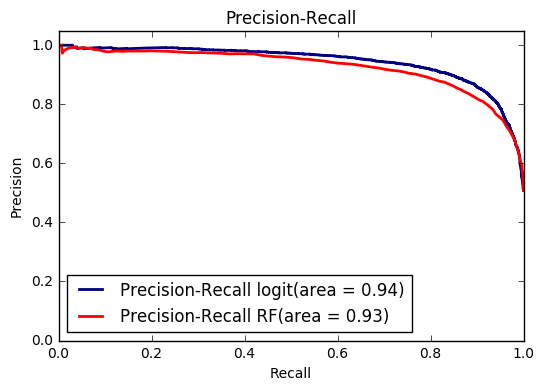

In [54]:
plt.clf()
plt.plot(recalll, precisionl, lw=2, color='navy',label='Precision-Recall logit(area = {0:0.2f})'
               ''.format(average_precision_logit))
plt.plot(recallr, precisionr, lw=2, color='red',label='Precision-Recall RF(area = {0:0.2f})'
               ''.format(average_precision_RF))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")
plt.show()

In [57]:
fpr_logit, tpr_logit, thresholds = roc_curve(yval, yLogit[:,1])
fpr_RF, tpr_RF, thresholds = roc_curve(yval, yRF[:,1])
AUC_logit = auc(fpr_logit, tpr_logit)
AUC_RF = auc(fpr_RF, tpr_RF)

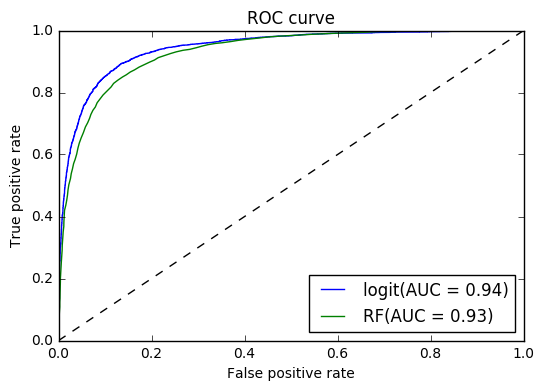

In [58]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logit, tpr_logit, label='logit(AUC = {0:0.2f})'
               ''.format(AUC_logit))
plt.plot(fpr_RF, tpr_RF, label='RF(AUC = {0:0.2f})'
               ''.format(AUC_RF))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Если мы хотим, чтобы классификатор находил, например, не менее 80% положительных отзывов, то необходимо потребовать, чтобы полнота была не менее 0.8. 

**(0.5 балла) Задание 3.**

Найдите наибольшую точность, которую будет иметь каждый классификатор при полноте не менее 0.8.

In [64]:
print("logit",np.max(precisionl[recalll>0.8]))
print("RF",np.max(precisionr[recallr>0.8]))

logit 0.918408975013
RF 0.885546588408


В дальнейшем для экпериментов будем использовать логистическую регрессию. Можно заметить, что по некоторым причинам мы не находили оптимальные параметры для алгоритмов, а работали с параметрами по умолчанию. Чтобы исправить этот недостаток, в дальнейшем используйте кросс-валидацию по 5 блокам для нахождения наилучшего параметра *C* у логистической регрессии. Для этого удобно использовать класс [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) с оптимизацией *roc_auc*. Значения параметра *C* можно перебирать по логарифмической шкале и ограничиться 3-5 значениями.

А теперь вернемся к исходной задаче. На данном этапе решения можно прийти к выводу, что предложенное кодирование текста может быть не самым удачным. Это ведет как к ситуации, что не всякий алгоритм может быть применен в данной задаче по причине слишком большого признакового пространства, а кроме того, даже быстрые алгоритмы при наличии кросс-валидации могут начать работать медленно. Также в данных может быть шум, так как в качестве словаря были взяты все слова, даже те, которые встречались в одном-двух отзывах (например, опечатки). Поэтому кажется что неплохо было бы сократить размерность данных и по возможности избавиться от шума. 

## Отбор признаков и уменьшение размерности

### По частоте
Попробуем сформировать выборку, в которой будут находиться только самые "важные" признаки, то есть в данном случае слова. Например, это можно сделать оставив топ слов по частоте. Кажется, что вхождение наиболее частых слов в отзыве, например *good*, *bad* и т.д. являются вполне неплохими показателями.

### С помощью машинного обучения
Другой подход — воспользоваться имеющимся машинным обучением — обученным на всех признаках случайным лесом. Одним из свойств случайного леса является оценка важности признаков. Таким образом, можно выбрать топ слов, важных как признаки для задачи классификации. 

### Hashing trick
Какие еще могут быть способы работы с такого рода данными? По факту слова в текстах — это некоторое очень разреженное представление (как мы убедились выше). Подходом, отличным от двух вышеперечисленных, является [хэширование](https://en.wikipedia.org/wiki/Feature_hashing) или hashing trick: каждому слову сопоставляется некоторый хэш, после чего делается, например, bag-of-words. Из-за коллизий можно обработать не встречавшихся ранее слов. Этот подход реализован в классе [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html). Кроме того, если выставить параметр *non_negative=True*, то можно интерпретировать полученные значения как некоторые "частоты".

Можно заметить, что два последних подхода можно применять не обязательно к текстовым данным.

Подберем оптимальный параметр регуляризации

In [129]:
C = np.array([1,2,3,4,5,6,7,8,9,10])
a = []
for c in C:
    lr = LogisticRegressionCV(Cs=c, cv=3,  penalty='l2', scoring='roc_auc',  n_jobs=-1,  random_state=7)
    lr.fit(Xtr,ytr)
    print(lr.score(Xval, yval))
    a.append(lr.score(Xval, yval))
    
C[np.argmax(a)]

0.762666666667
0.861222222222
0.875888888889
0.882888888889
0.876222222222
0.881666666667
0.882888888889
0.880777777778
0.881444444444
0.882888888889


4

**(1 балл) Задание 4.**

Сформируйте три новые выборки, где каждый объект будет иметь 15000 признаков, следующим образом:
 - топ самых частотных слов
 - топ наиболее "важных" слов с помощью случайного леса
 - с помощью хэширования
 
(и не забывайте фильтровать стоп-слова).

На четырех выборках (*bag-of-words* и трех новых) постройте *roc*-кривые, вычислив площадь под ними. Что вы можете сказать о качестве этих подходов к сокращению размерности?

Выведите топ20 самых важных слов от случайного леса и сравните их с топ20 наиболее частотных. Много ли общих слов?

топ самых частотных слов

In [306]:
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
Xtr.shape,Xval.shape

((16000,), (9000,))

In [307]:
cv = CountVectorizer(max_features = 15000,stop_words = 'english')
cv.fit(Xtr)
print(len(cv.vocabulary_))
Xtr = cv.transform(Xtr)
Xval = cv.transform(Xval)
Xtr.shape,Xval.shape

15000


((16000, 15000), (9000, 15000))

In [308]:
logit = LogisticRegression(C = 4,penalty='l2',n_jobs=-1, random_state=7)
logit.fit(Xtr, ytr)
yLogit15k = logit.predict_proba(Xval)
fpr_freq, tpr_freq, thresholds = roc_curve(yval, yLogit15k[:,1])
AUC_freq = auc(fpr_freq, tpr_freq)


Топ наиболее "важных" слов с помощью случайного леса

In [228]:
importances = RF.feature_importances_

In [229]:
ins = np.sort(importances)[::-1]
ins[14999:15000]

array([  6.58405571e-06])

In [309]:
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
Xtr.shape,Xval.shape

((16000,), (9000,))

In [310]:
cv = CountVectorizer(stop_words = 'english')
cv.fit(Xtr)
print(len(cv.vocabulary_))
Xtr = cv.transform(Xtr)
Xval = cv.transform(Xval)
Xtr.shape,Xval.shape

62253


((16000, 62253), (9000, 62253))

In [311]:
from sklearn.feature_selection import SelectFromModel

In [312]:
model = SelectFromModel(RF, prefit=True,threshold =6.58405570e-06)
Xtr = model.transform(Xtr)
Xval = model.transform(Xval)
Xtr.shape,Xval.shape

((16000, 15000), (9000, 15000))

In [313]:
logit.fit(Xtr, ytr)
yLogitrf15k = logit.predict_proba(Xval)
fpr_RF, tpr_RF, thresholds = roc_curve(yval, yLogitrf15k[:,1])
AUC_RF = auc(fpr_RF, tpr_RF)

с помощью хэширования

In [251]:
from sklearn.feature_extraction.text import HashingVectorizer

In [314]:
hv = HashingVectorizer(stop_words = 'english',non_negative=True,n_features = 15000)

In [315]:
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
Xtr.shape,Xval.shape

((16000,), (9000,))

In [316]:
hv.fit(Xtr)
#print(len(hv.vocabulary_))
Xtr = hv.transform(Xtr)
Xval = hv.transform(Xval)
Xtr.shape,Xval.shape

((16000, 15000), (9000, 15000))

In [317]:
logit.fit(Xtr, ytr)
yLogith15k = logit.predict_proba(Xval)
fpr_h, tpr_h, thresholds = roc_curve(yval, yLogith15k[:,1])
AUC_h = auc(fpr_h, tpr_h)

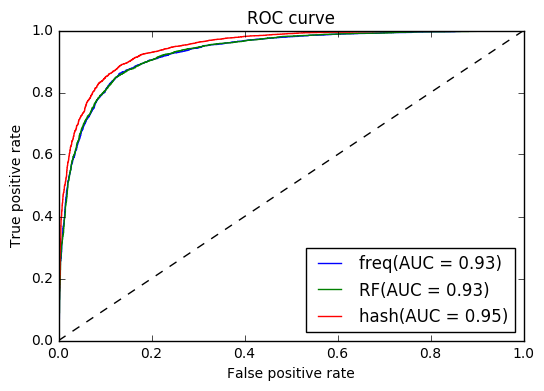

In [259]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_freq, tpr_freq, label='freq(AUC = {0:0.2f})'
               ''.format(AUC_freq))
plt.plot(fpr_RF, tpr_RF, label='RF(AUC = {0:0.2f})'
               ''.format(AUC_RF))
plt.plot(fpr_h, tpr_h, label='hash(AUC = {0:0.2f})'
               ''.format(AUC_h))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

подходы не сильно ухудшают качество при сильном уменьшении размерности пространтсва. Hash подход даже улучшил результаты

In [246]:
#топ слов для RF
indices = np.argsort(importances)[::-1]
di = list(cv.vocabulary_)
for f in range(20):
    print(f , list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(indices[f])], importances[indices[f]])

0 bad 0.0121014878592
1 worst 0.011662569032
2 great 0.00706810766905
3 awful 0.00692683437561
4 waste 0.00663855621995
5 boring 0.00423781570452
6 terrible 0.00420518702997
7 wonderful 0.00403770673189
8 excellent 0.00401322614865
9 best 0.0038406523343
10 horrible 0.00356281436843
11 worse 0.00324695060102
12 just 0.00322526340325
13 poor 0.0031074275024
14 plot 0.00305874156823
15 movie 0.0030515395198
16 love 0.00297255737858
17 minutes 0.0028350176123
18 stupid 0.00276489397589
19 perfect 0.00254009194468


In [297]:
#топ слов по частоте 
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
Xtr.shape,Xval.shape
cv = CountVectorizer(max_features = 20,stop_words = 'english')
cv.fit(Xtr)
print(len(cv.vocabulary_))
cv.vocabulary_

20


{'bad': 0,
 'br': 1,
 'character': 2,
 'characters': 3,
 'don': 4,
 'film': 5,
 'good': 6,
 'great': 7,
 'just': 8,
 'like': 9,
 'make': 10,
 'movie': 11,
 'movies': 12,
 'people': 13,
 'really': 14,
 'story': 15,
 'think': 16,
 'time': 17,
 'watch': 18,
 'way': 19}

Видим, что некоторые слова совпадают

Таким образом, удалось сократить размерность более чем в три раза без сильной потери в качестве. Но даже 15000 признаков — это достаточно много. Допустим, мы хотим уменьшить размерность до 2000 признаков, однако можно заметить, что даже три предыдущие способа давали небольшое ухудшение в качестве. 

### PCA

Одним из способов сокращения размерности является [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (метод главных компонент). Это преобразование позволяет получить вес каждого признака в компоненте. Например, если применить его к bag-of-words, можно найти наиболее важные слова, влияющие на данную компоненту. Для работы с большими разреженными матрицами в sklearn рекомендуется использовать [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). Обратите внимание, что обучение этого преобразования может работать около 3-5 минут.

**(1 балл) Задание 5.**

Попробуйте сократить размерность до 2000 двумя способами:
 - наилучшим из трех предыдущих
 - для выборки со всеми признаками обучите *PCA*-преобразование 

Постройте новый график качества. Какой из двух подходов работает лучше?

Для первых трех компонент преобразования найдите топ30 наиболее важных слов. Можете ли вы охарактеризовать как-то каждую из этих групп?

In [260]:
from sklearn.decomposition import TruncatedSVD
TR = TruncatedSVD(n_components=2000, algorithm='randomized', n_iter=5, random_state=7)

In [263]:
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
Xtr.shape,Xval.shape

((16000,), (9000,))

In [266]:
cv = CountVectorizer(stop_words = 'english')
cv.fit(Xtr)
print(len(cv.vocabulary_))
Xtr = cv.transform(Xtr)
Xval = cv.transform(Xval)
Xtr.shape,Xval.shape

62253


((16000, 62253), (9000, 62253))

In [267]:
TR.fit(Xtr)
#print(len(hv.vocabulary_))
Xtr = TR.transform(Xtr)
Xval = TR.transform(Xval)
Xtr.shape,Xval.shape

((16000, 2000), (9000, 2000))

In [268]:
logit = LogisticRegression(C = 4,penalty='l2',n_jobs=-1, random_state=7)
logit.fit(Xtr, ytr)
yLogit_TR = logit.predict_proba(Xval)
fpr_freq_tr, tpr_freq_tr, thresholds = roc_curve(yval, yLogit_TR[:,1])
AUC_freq_tr = auc(fpr_freq_tr, tpr_freq_tr)

In [291]:
top_comp = TR.components_[:3,:]
top_comp

array([[  4.95449755e-04,   2.24611589e-03,   1.35261201e-05, ...,
          3.99275943e-06,   1.27807685e-05,   3.20245081e-05],
       [ -4.57920595e-04,  -9.04734820e-04,  -3.67323500e-05, ...,
         -2.19078832e-05,   9.44057924e-06,  -8.23094013e-07],
       [  5.69648195e-05,   1.35332190e-03,  -3.80183748e-05, ...,
         -1.98561184e-05,  -2.67952984e-06,   4.86426524e-05]])

In [298]:
cv = CountVectorizer(stop_words = 'english')
cv.fit(Xtr)
print(len(cv.vocabulary_))
Xtr = cv.transform(Xtr)
Xval = cv.transform(Xval)
Xtr.shape,Xval.shape

62253


((16000, 62253), (9000, 62253))

выведем топ 30 важных слов для первых трех компонент

In [299]:
#топ слов для каждой компоненты

for i in range(3):
    print("Component",i+1)
    indices = np.argsort(top_comp[i])[::-1]
    for f in range(30):
        print(f ,list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(indices[f])])

Component 1
0 br
1 film
2 movie
3 like
4 just
5 good
6 time
7 story
8 really
9 people
10 bad
11 don
12 great
13 way
14 make
15 character
16 characters
17 think
18 movies
19 films
20 life
21 little
22 man
23 does
24 love
25 know
26 did
27 scene
28 plot
29 seen
Component 2
0 br
1 match
2 basket
3 season
4 khouri
5 wrestlemania
6 wwe
7 episodes
8 episode
9 championship
10 chavez
11 milo
12 wench
13 undertaker
14 starr
15 kareena
16 erika
17 zorro
18 gadget
19 bathsheba
20 wwf
21 coop
22 austin
23 sable
24 triple
25 burns
26 seasons
27 dibiase
28 tavern
29 gundam
Component 3
0 film
1 films
2 man
3 story
4 director
5 work
6 character
7 young
8 characters
9 life
10 quite
11 does
12 world
13 best
14 years
15 woman
16 horror
17 time
18 cinema
19 performance
20 scenes
21 role
22 war
23 new
24 fact
25 american
26 great
27 interesting
28 screen
29 early


In [269]:
AUC_freq_tr

0.93443432098765433

In [300]:
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
Xtr.shape,Xval.shape

((16000,), (9000,))

In [301]:
hv = HashingVectorizer(stop_words = 'english',non_negative=True,n_features = 2000)

In [302]:
hv.fit(Xtr)
#print(len(hv.vocabulary_))
Xtr = hv.transform(Xtr)
Xval = hv.transform(Xval)
Xtr.shape,Xval.shape

((16000, 2000), (9000, 2000))

In [303]:
logit.fit(Xtr, ytr)
yLogith2k = logit.predict_proba(Xval)
fpr_h2k, tpr_h2k, thresholds = roc_curve(yval, yLogith2k[:,1])
AUC_h2k = auc(fpr_h2k, tpr_h2k)

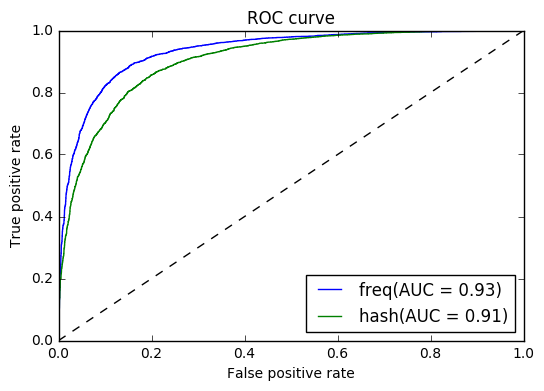

In [305]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_freq_tr, tpr_freq_tr, label='freq(AUC = {0:0.2f})'
               ''.format(AUC_freq_tr))
plt.plot(fpr_h2k, tpr_h2k, label='hash(AUC = {0:0.2f})'
               ''.format(AUC_h2k))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

видим, что лучше всего показал себя PCA

### Какие еще могут быть способы обработки текстовых данных?

Как можно заметить, подход с мешком слов весьма наивен, так как не позволяет учесть информацию в скольки отзывах встречалось слово (чтобы избавиться от очень редких слов, например). В этом случае может помочь, например, [tf-idf кодирование](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

Другой недостаток описанного в задании подхода — брать абсолютные частоты. У некоторых слов они могут быть очень большими, в то же время у других — низкими. Чтобы "сгладить" разницу между ними, можно их отлогарифмировать, т.е. применить преобразование $x \to log(x + 1)$ (так как при bag-of-words кодировании могут встречаться 0).

Неплохое руководство можно найти в разделе [извлечения признаков](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) из документации sklearn.


Можно устранить ошибки в словах, привести к одному формату, выкинуть мусор из текста, можно обучить вордтувек и работать не с таким большим пространством признаков, так как он сможет уловить связи

## Stacking

Итак, сейчас имеется несколько разных способов охарактеризовать исходный датасет:
 - bag-of-words
 - bag-of-words для 15000 наиболее частотных слов
 - bag-of-words для 15000 наиболее важных признаков
 - признаки, полученные в результате хэширования
 - применение PCA для bag-of-words

Во второй лабораторной вы пробовали линейно смешивать несколько классификаторов для улучшения итогового качества, перебирая коэффициенты смешивания по сетке. А вообще говоря, подбор оптимальных линейных коэффициентов — это задача обучения линейной модели, которую мы уже давно изучаем в курсе. Так что давайте попробуем смешивать базовые алгоритмы, подбирая коэффициенты с помощью обученной поверх их предсказаний линейной мета-модели. В этом случае схема обучения будет выглядеть следующим образом:

![](http://cse-wiki.unl.edu/wiki/images/5/54/Combining_classifiers_overview.png)

Такой подход, когда предсказания одних алгоритмов подаются на вход другому алгоритму, называется stacking. Плюс такого подхода будет заключаться в том, что новое признаковое описание будет небольшим, поэтому можно легко использовать любые известные вам методы.

**(1.5 балла) Задание 6.**

 - Объясните, будет ли происходить переобучение, если обучать базовые алгоритмы и мета-модель на одной и той же выборке? Для простоты можете представить, что в качестве базового алгоритма используется 1-NN.
 - Для начала разделите каждую обучающую выборку на две части и на одной из частей обучите базовые классификаторы (в данном случае — логистическую регрессию). Сделайте разделение таким образом, чтобы для обучения мета-алгоритма осталось 4000 объектов.
 - Сделайте предсказание этих классификаторов на оставшейся части
 - На ответах классификаторов обучите новый классификатор, который и будет являться мета-алгоритмом. В качестве мета-классификатора рассматрите SVM с линейным ядром, логистическую регрессию и случайный лес со 100 деревьями. 

Для всех ли мета-классификаторов этот подход дал прирост в качестве?

Переобучение будет происходить в связи с тем, что мы изначально фитимся под выборку,а после это еще фитимся в мета-модели давая информацию из будущего, которой не должно быть.

In [7]:
Xmeta_prob = pd.DataFrame()
Xval_prob = pd.DataFrame()

In [8]:
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
Xtr, Xmeta, ytr, ymeta = train_test_split(Xtr, ytr, test_size=0.25,stratify = ytr,random_state=7)
print(Xtr.shape,Xmeta.shape,Xval.shape)
cv = CountVectorizer(stop_words = 'english')
cv.fit(Xtr)
print(len(cv.vocabulary_))
Xtr = cv.transform(Xtr)
Xmeta = cv.transform(Xmeta)
Xval = cv.transform(Xval)
print(Xtr.shape,Xmeta.shape,Xval.shape)
logit = LogisticRegression(C = 4,penalty='l2',n_jobs=-1, random_state=7)
logit.fit(Xtr, ytr)
Xmeta_prob['All_feat'] = logit.predict_proba(Xmeta)[:,1]
Xval_prob['All_feat'] = logit.predict_proba(Xval)[:,1]

(12000,) (4000,) (9000,)
55305
(12000, 55305) (4000, 55305) (9000, 55305)


In [9]:
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
Xtr, Xmeta, ytr, ymeta = train_test_split(Xtr, ytr, test_size=0.25,stratify = ytr,random_state=7)
print(Xtr.shape,Xmeta.shape,Xval.shape)
cv = CountVectorizer(max_features = 15000,stop_words = 'english')
cv.fit(Xtr)
print(len(cv.vocabulary_))
Xtr = cv.transform(Xtr)
Xmeta = cv.transform(Xmeta)
Xval = cv.transform(Xval)
print(Xtr.shape,Xmeta.shape,Xval.shape)
logit = LogisticRegression(C = 4,penalty='l2',n_jobs=-1, random_state=7)
logit.fit(Xtr, ytr)
Xmeta_prob['15k_freq'] = logit.predict_proba(Xmeta)[:,1]
Xval_prob['15k_freq'] = logit.predict_proba(Xval)[:,1]


(12000,) (4000,) (9000,)
15000
(12000, 15000) (4000, 15000) (9000, 15000)


In [10]:
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
Xtr, Xmeta, ytr, ymeta = train_test_split(Xtr, ytr, test_size=0.25,stratify = ytr,random_state=7)
print(Xtr.shape,Xmeta.shape,Xval.shape)
hv = HashingVectorizer(stop_words = 'english',non_negative=True,n_features = 15000)
hv.fit(Xtr)
#print(len(hv.vocabulary_))
Xtr = hv.transform(Xtr)
Xmeta = hv.transform(Xmeta)
Xval = hv.transform(Xval)
print(Xtr.shape,Xmeta.shape,Xval.shape)
logit = LogisticRegression(C = 4,penalty='l2',n_jobs=-1, random_state=7)
logit.fit(Xtr, ytr)
Xmeta_prob['15k_hash'] = logit.predict_proba(Xmeta)[:,1]
Xval_prob['15k_hash'] = logit.predict_proba(Xval)[:,1]

(12000,) (4000,) (9000,)
(12000, 15000) (4000, 15000) (9000, 15000)


In [11]:
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
Xtr, Xmeta, ytr, ymeta = train_test_split(Xtr, ytr, test_size=0.25,stratify = ytr,random_state=7)
print(Xtr.shape,Xmeta.shape,Xval.shape)
cv = CountVectorizer(stop_words = 'english')
cv.fit(Xtr)
print(len(cv.vocabulary_))
Xtr = cv.transform(Xtr)
Xmeta = cv.transform(Xmeta)
Xval = cv.transform(Xval)
print(Xtr.shape,Xmeta.shape,Xval.shape)
RF = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=7)
RF.fit(Xtr, ytr)
model = SelectFromModel(RF, prefit=True,threshold =6.64502397e-06)
Xtr = model.transform(Xtr)
Xmeta = model.transform(Xmeta)
Xval = model.transform(Xval)
print(Xtr.shape,Xmeta.shape,Xval.shape)
logit = LogisticRegression(C = 4,penalty='l2',n_jobs=-1, random_state=7)
logit.fit(Xtr, ytr)
Xmeta_prob['15k_imp_RF'] = logit.predict_proba(Xmeta)[:,1]
Xval_prob['15k_imp_RF'] = logit.predict_proba(Xval)[:,1]

(12000,) (4000,) (9000,)
55305
(12000, 55305) (4000, 55305) (9000, 55305)
(12000, 15000) (4000, 15000) (9000, 15000)


In [12]:
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
Xtr, Xmeta, ytr, ymeta = train_test_split(Xtr, ytr, test_size=0.25,stratify = ytr,random_state=7)
print(Xtr.shape,Xmeta.shape,Xval.shape)
cv = CountVectorizer(stop_words = 'english')
cv.fit(Xtr)
print(len(cv.vocabulary_))
Xtr = cv.transform(Xtr)
Xmeta = cv.transform(Xmeta)
Xval = cv.transform(Xval)
print(Xtr.shape,Xmeta.shape,Xval.shape)
TR = TruncatedSVD(n_components=2000, algorithm='randomized', n_iter=5, random_state=7)
TR.fit(Xtr)
Xtr = TR.transform(Xtr)
Xmeta = TR.transform(Xmeta)
Xval = TR.transform(Xval)
print(Xtr.shape,Xmeta.shape,Xval.shape)
logit = LogisticRegression(C = 4,penalty='l2',n_jobs=-1, random_state=7)
logit.fit(Xtr, ytr)
Xmeta_prob['pca'] = logit.predict_proba(Xmeta)[:,1]
Xval_prob['pca'] = logit.predict_proba(Xval)[:,1]

(12000,) (4000,) (9000,)
55305
(12000, 55305) (4000, 55305) (9000, 55305)
(12000, 2000) (4000, 2000) (9000, 2000)


До этого момента лучше всего показало себя хеширование признаков до 15к, поэтому будем сравнивать результат мета классификатора с ним

In [15]:
Xtr, Xval, ytr, yval = train_test_split(data['review'], y, test_size=0.36,stratify = y,random_state=7)
print(Xtr.shape,Xval.shape)
hv = HashingVectorizer(stop_words = 'english',non_negative=True,n_features = 15000)
hv.fit(Xtr)
#print(len(hv.vocabulary_))
Xtr = hv.transform(Xtr)
Xval = hv.transform(Xval)
print(Xtr.shape,Xval.shape)
logit = LogisticRegression(C = 4,penalty='l2',n_jobs=-1, random_state=7)
logit.fit(Xtr,ytr)
pred_l = logit.predict_proba(Xval)[:,1]
fpr_l, tpr_l, thresholds = roc_curve(yval, pred_l)
AUC_l = auc(fpr_l, tpr_l)
print("normal_hash_15k",AUC_l)

(16000,) (9000,)
(16000, 15000) (9000, 15000)
normal_hash_15k 0.946890962963


In [17]:
from sklearn.svm import SVC
svm = SVC( C=1, kernel='linear', random_state=7,probability = True)
svm.fit(Xmeta_prob,ymeta)
pred_svm = svm.predict_proba(Xval_prob)[:,1]
fpr_svm, tpr_svm, thresholds = roc_curve(yval, pred_svm)
AUC_svm = auc(fpr_svm, tpr_svm)
print("meta_prob_SVM",AUC_svm)

meta_prob_SVM 0.945562024691


In [21]:
logit = LogisticRegression(C = 4,penalty='l2',n_jobs=-1, random_state=7)
logit.fit(Xmeta_prob,ymeta)
pred_logit = logit.predict_proba(Xval_prob)[:,1]
fpr_logit, tpr_logit, thresholds = roc_curve(yval, pred_logit)
AUC_logit = auc(fpr_logit, tpr_logit)
print("meta_prob_logit",AUC_logit)

meta_prob_logit 0.946506666667


In [19]:
RF = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=7)
RF.fit(Xmeta_prob, ymeta)
pred_rf = RF.predict_proba(Xval_prob)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(yval, pred_rf)
AUC_rf = auc(fpr_rf, tpr_rf)
print("meta_prob_RF",AUC_rf)

meta_prob_RF 0.93812182716


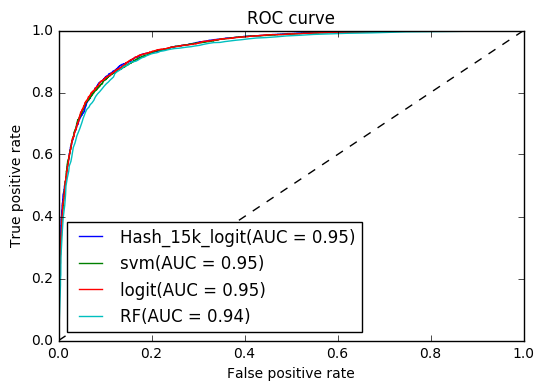

In [20]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_l, tpr_l, label='Hash_15k_logit(AUC = {0:0.2f})'
               ''.format(AUC_l))
plt.plot(fpr_svm, tpr_svm, label='svm(AUC = {0:0.2f})'
               ''.format(AUC_svm))
plt.plot(fpr_logit, tpr_logit, label='logit(AUC = {0:0.2f})'
               ''.format(AUC_logit))
plt.plot(fpr_rf, tpr_rf, label='RF(AUC = {0:0.2f})'
               ''.format(AUC_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Видим, что все классификаторы работают примерно одинаково, хуже всего мета RF 0.93812182716, лучше всего обычное хеширование до 15к 0.946890962963, не сильно далеко от него мета SVM 0.945562024691. 

## Подбор гиперпараметров

Вы уже знаете, что для подбора гиперпараметров есть способ перебора по сетке. Обычно перебор некоторых значений гиперпараметров ведется по логарифмической шкале, так как это позволяет быстрее определить какого порядка должен быть параметр, и в то же время значительно уменьшить время поиска. Последний нюанс бывает особо критичен, т.к. для каждого фиксированного набора параметров происходит обучение алгритма и оценка качества. 

Однако такой подход к нахождению гиперпараметров является не единственно возможным. Рассмотрим более конкретно в чем может заключаться недостаток предыдущего подхода. Допустим, вам нужно подобрать 2 гиперпараметра, для каждого из которых есть сетка из 4 возможных значений. То есть всего 16 итераций обучения по сетке. Допустим также, что для оценки качества используется 5-fold CV. В итоге имеем 80 переобучений алгоритма, что уже немало. А если, например, рассмотреть случаный лес, где гиперпараметрами могут являться критерий ветвления, максимальная глубина деревьев, минимальное число объектов в листьях, максимальное число признаков, количество листьев и так далее, может получиться экспоненциально большое число переобучений, что займёт очень много времени. Для того чтобы как-то ускорить процесс и в то же время найти близкие к оптимальным значения используют случайный поиск по сетке. В этом случае для каждого гиперпараметра задается распределение, из которого он выбирается. И так как каждый раз значение каждого гиперпараметра выбирается случайно, это позволяет находить оптимальные значения быстрее. 

Если сравнить случайный поиск с обычным, то это можно проиллюстрировать, например, следующим образом:

![](http://blog.kaggle.com/wp-content/uploads/2015/07/scikitlearn8.jpeg)

Более подробно можно прочитать тут:
 - теоретический анализ случайного поиска [Random Search for Hyper-Parameter Optimization](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)
 - кратко и с юмором [Smarter Parameter Sweeps (or Why Grid Search Is Plain Stupid)](https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881#.pkwq17od8)
 
В sklearn случайный поиск по сетке реализован в классе [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html).

Давайте попробуем сравнить описанные подходы на практике. А именно, посмотрим, как ведет себя обычный и случайный поиск по сетке при одинаковом бюджете (то есть числе итераций). Попробуем найти аптимальные гиперпараметры для мета-классификатора выше: SVM с линейным ядром. В данном случае нам будет интересны найти значения у двух параметров: *C* и количество итераций *max_iter*. Для обоих гиперпараметров возьмите логарифмическую шкалу, для *C* от 0.1 до 100, для *max_iter* от 1000 до 10000 (см. функцию [logspace](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.logspace.html)). В качестве оптимизируемой метрики качества выберем *AUC-ROC*.

**(2 балла) Задание 7.**

 - Для простого поиска по сетке подготовьте 5 сеток гиперпараметров, так чтобы каждый у каждого гиперпараметра перебиралось 2, 3, 4, 5 и 6 значений в соответствующей сетке. Таким образом у вас получится 5 запусков поиска параметров с бюджетом 4, 9, 16, 25, 36. 

 - Для случайного поиска сделайте 5 запусков поиска гиперпараметров с числом итераций (бюджетом) 4, 9, 16, 25, 36. 

 - Для каждого из запусков алгоритма подбора гиперпараметров (одного — обычной и 5 для случайной) вычислите наилучшее достигнутое качество для каждого бюджета. После чего постройте график, где по оси OX будет отложен бюджет, а по оси OY — наилучшее качество. 
 
Что вы можете сказать о получившемся графике? Посмотрите на наилучшие параметры, которые у вас получились. Можно ли сказать, что какой-то из параметров больше влияет на результат? Можно ли сделать вывод, что случайный поиск проигрывает? Или наоборот? Зависит ли ответ на предыдущий вопрос от размера бюджета или удачной инициализации?

Обратите внимание, что данная часть лабораторной работы может работать долго. Поэтому рекомендуем обратить внимание на параметр *n_jobs* поиска по сетке (есть у обоих классов).

Для простого поиска по сетке

In [44]:

p = [{'C':[0.1,100],'max_iter':[1000,10000]},{'C':[0.1,50,100],'max_iter':[1000,5000,10000]},\
    {'C':[0.1,10,50,100],'max_iter':[1000,3000,5000,10000]},{'C':[0.1,1,10,50,100],'max_iter':[1000,3000,5000,8000,10000]},\
    {'C':[0.1,1,5,10,50,100],'max_iter':[1000,2000,3000,5000,8000,10000]}]
svm = SVC(  kernel='linear', random_state=7,probability = True)
par_g = []
score_g = []
for i in range(5):
    parameters = p[i]
    clf = GridSearchCV(svm, parameters, cv = 5,scoring='roc_auc',n_jobs=-1)
    clf.fit(Xmeta_prob, ymeta)
    par_g.append(clf.best_params_)
    score_g.append(clf.best_score_)
    print("number_setki:",i)
    print("Best params:", clf.best_params_)
    print("Best cross validaton score:", clf.best_score_)

number_setki: 0
Best params: {'C': 0.1, 'max_iter': 1000}
Best cross validaton score: 0.94668625
number_setki: 1
Best params: {'C': 0.1, 'max_iter': 1000}
Best cross validaton score: 0.94668625
number_setki: 2
Best params: {'C': 0.1, 'max_iter': 1000}
Best cross validaton score: 0.94668625
number_setki: 3
Best params: {'C': 1, 'max_iter': 1000}
Best cross validaton score: 0.94683
number_setki: 4
Best params: {'C': 1, 'max_iter': 1000}
Best cross validaton score: 0.94683


In [112]:

#parameters = {'C':[0.1,1,10,50,100],'max_iter':[1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]}
param = {'C':sp_rand(0.1, 100),'max_iter':sp_rand(1000, 10000)}
svm = SVC(  kernel='linear', random_state=7,probability = True)
par_r = []
score_r = []
for i in [4,9,16,25,36]:
    rs = RandomizedSearchCV(svm, param_distributions=param,scoring='roc_auc', n_iter=i,n_jobs=-1)
    rs.fit(Xmeta_prob, ymeta)
    par_r.append(rs.best_params_)
    score_r.append(rs.best_score_)

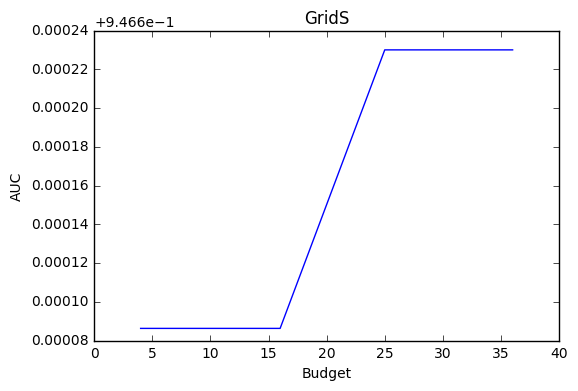

In [43]:
plt.plot(np.array([4,9,16,25,36]),np.array(score_g))
plt.xlabel('Budget')
plt.ylabel('AUC')
plt.title('GridS')
plt.legend(loc='best')
plt.show()

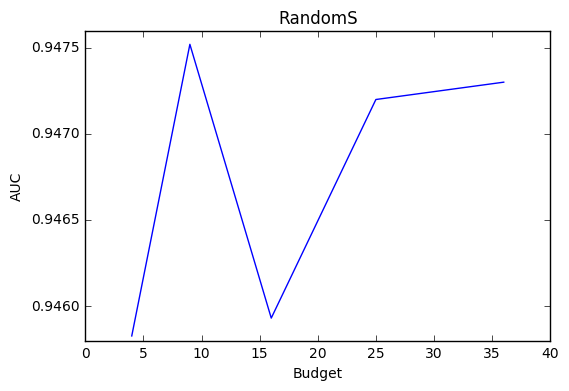

In [48]:
plt.plot(np.array([4,9,16,25,36]),np.array(score_r))
plt.xlabel('Budget')
plt.ylabel('AUC')
plt.title('RandomS')
plt.legend(loc='best')
plt.show()

Видно, что для GridS при увеличении бюджета можно найти лучшие параметры для алгоритма , которые улучшают его качество. Но начиная с некоторого момента увеличивать бюджет не имеет смысла. Для RandomS все зависит от удачи инициализации поэтому график получился таким скачущим.
В обоих случаях параметр C оказывает большее влияние на результат в отличии от max_iter.
В данном случае RandomS был лучше чем GridS 0.947519799785>0.94683 c наилучшими параметрами 'C': 74, 'max_iter': 1594, но это просто так повезло с инициализацией, в остальных итерациях он проиграл. RandomS быстрее работает чем GridS при большом числе перебираемых параметров, при этом если увеличивать n_iter то можно повысить вероятноятность найти оптимальные параметры.

In [23]:
np.logspace(0.1, 100,  endpoint=True, base=10.0, )

array([  1.25892541e+000,   1.37649776e+002,   1.50505032e+004,
         1.64560853e+006,   1.79929362e+008,   1.96733152e+010,
         2.15106266e+012,   2.35195264e+014,   2.57160393e+016,
         2.81176870e+018,   3.07436270e+020,   3.36148062e+022,
         3.67541279e+024,   4.01866341e+026,   4.39397056e+028,
         4.80432804e+030,   5.25300922e+032,   5.74359321e+034,
         6.27999335e+036,   6.86648845e+038,   7.50775694e+040,
         8.20891416e+042,   8.97555318e+044,   9.81378942e+046,
         1.07303094e+049,   1.17324241e+051,   1.28281274e+053,
         1.40261596e+055,   1.53360772e+057,   1.67683294e+059,
         1.83343411e+061,   2.00466042e+063,   2.19187774e+065,
         2.39657948e+067,   2.62039853e+069,   2.86512027e+071,
         3.13269683e+073,   3.42526264e+075,   3.74515148e+077,
         4.09491506e+079,   4.47734343e+081,   4.89548719e+083,
         5.35268182e+085,   5.85257434e+087,   6.39915234e+089,
         6.99677582e+091,   7.65021198e+

## Калибровка классификатора

Для измерения качества классификации помимо описанных ранее метрик может использоваться, например, *logloss*. 

В бинарном случае эта метрика записывается как $$logloss = -\dfrac{1}{N}\sum_{i=1}^N (y_i\log{p_i} + (1-y_i)\log{(1 - p_i)})$$

В отличии от *AUC-ROC*, для этой метрики необходимо, чтобы классификатор умел предсказывать вероятность принадлежности к классу, а не "степени принадлежности классу 1" в неопределенной шкале. Приведем пример. Вероятностная шкала может быть нужна, если вы хотите оценить количество денег, которые в среднем принесёт пользователь, кликнув на баннер. Для этого необходимо умножить количество денег, которые вы получаете за клик на баннер, на вероятность клика пользователя, которую предсказывает модель.

К сожалению, на практике часто получается так, что либо классификатор не обладает желаемым свойством (например, SVM без специальных настроек), либо метод *predict_proba* возвращает некорректную вероятность (например, случайный лес возвращает среднее арифметическое вероятностей от каждого дерева, которое не обязано являться корректной вероятностью, подробнее [здесь](http://people.dsv.su.se/~henke/papers/bostrom08b.pdf)).

В этом случае возможны несколько подходов: 
 - заменить классификатор на тот, который умеет предсказывать вероятности
 - воспользоваться калибровкой ответов.
 
Первый случай не всегда подходит, поэтому остановимся на втором. По умолчанию SVM может вычислять отступ от данного объекта до разделяющей гиперплоскости, а не возвращать вероятности. После чего можно обучить преобразование, которое бы искажало бы возвращаемое значение в вероятность  — это и называется калибровкой. Есть несколько известных методов для этого:
 - калибровка Платта;
 - изотоническая регрессия.

Обратите внимание, что преобразование необходимо обучать на отложенной выборке (то есть классификатор и калибровка должны производиться на разных подмножествах данных), иначе можно переобучиться. Калибровку можно применять к любым классификаторам (где это разумно и необходимо), особенно к тем, которые не оптимизируют log-loss явно.

Для калибровки классификатора в sklearn возможны два подхода:
 - взять уже обученный классификатор и откалибровать его на отложенной выборке
 - откалибровать по кросс-валидации: калибровочному классификатору передается вся обучающая выборка, которая внутри разбивается на обучающую и калибровочную, после чего происходит усреднение вероятностей по фолдам.
 
Подробнее об этом можно прочитать в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV). Также [здесь](https://jmetzen.github.io/2015-04-14/calibration.html) узнать подробности о калибровке в sklearn от автора.

**(2 балла) Задание 8.**
 
Рассмотрим SVM из предыдущего пункта. Примените оба описанных выше подхода для калибровки Платта и изотонической регрессии. 
 - Для каждого из подходов постройте график, на котором будут изображены [калибровочные кривые](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html): идеальная, исходного классификатора, а также для каждого из методов на обучающей выборке. Эта кривая строится путем упорядочения всех объектов по предсказанному значению, которые разбиваются на бины. По оси OX откладывается среднее предсказанное значение вероятности по бину, а по OY — доля положительных примеров. В случае идеальных вероятностей это будет прямая.
 - Посчитайте *logloss* на тестовой выборке для исходного и классификатора после калибровки.
 - Дает ли калибровка прирост качества?
 - Какой из способов калибровки в данном случае работает лучше?
 - Какой из подходов (калибровка на отложенной выборке или по кросс-валидации) дает более хороший результат?
 - Почему калибровка практически не должна повлиять на *AUC-ROC*? 
 
Обратите внимание, что по умолчанию SVM не реализует метод *predict_proba*. Поэтому для него можно воспользоваться методом *decision_function*, который вернет значение отступа. После этого отмасштабируйте полученные отступы в интервал [0, 1], применив сигмоиду или линейное преобразование.

Построим используя кросс валидацию
sigmoid соответствует методу Платта

SVMlog_loss: 0.44628548721
calib_sigmoid_cv5log_loss: 0.323217170383
calib_isotonik_cv5log_loss: 0.314728605189


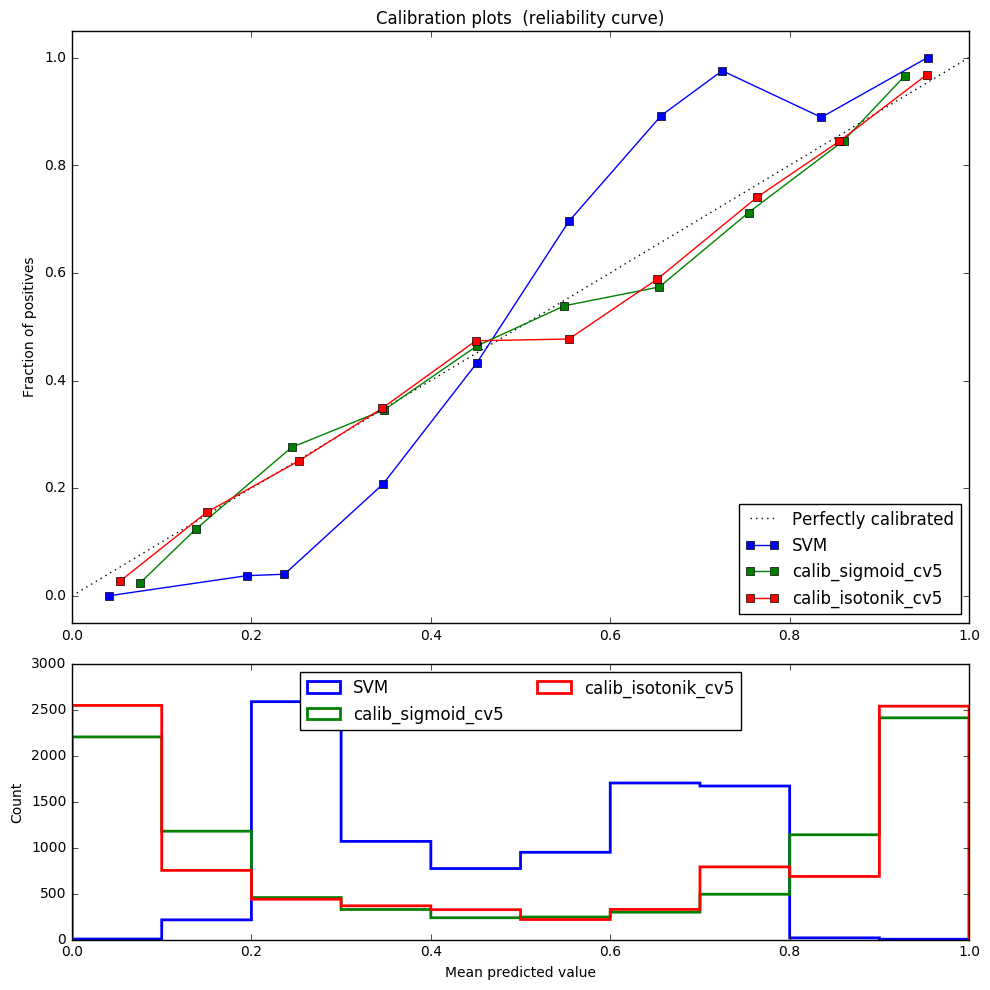

In [102]:
svm = SVC( C= 74, max_iter = 1594, kernel='linear', random_state=7,probability = False)
cl_sigmoid = CalibratedClassifierCV(base_estimator=svm, method='sigmoid', cv=5)
cl_isotonic = CalibratedClassifierCV(base_estimator=svm, method='isotonic', cv=5)
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(svm, 'SVM'),(cl_sigmoid,"calib_sigmoid_cv5"),(cl_isotonic,"calib_isotonik_cv5")]:
    clf.fit(Xmeta_prob, ymeta)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(Xval_prob)[:, 1]
        print(name+"log_loss:",log_loss(yval, prob_pos))
    else:  # use decision function
        prob_pos = clf.decision_function(Xval_prob)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        print(name+"log_loss:",log_loss(yval, prob_pos))
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(yval, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

Теперь построим другим способов, возьмем уже обученный классификатор и откалибрум его на отложенной выборке

svm_log_loss: 0.359817206577
calib_sigmoidlog_loss: 0.35127125842
calib_isotoniklog_loss: 0.354858749636


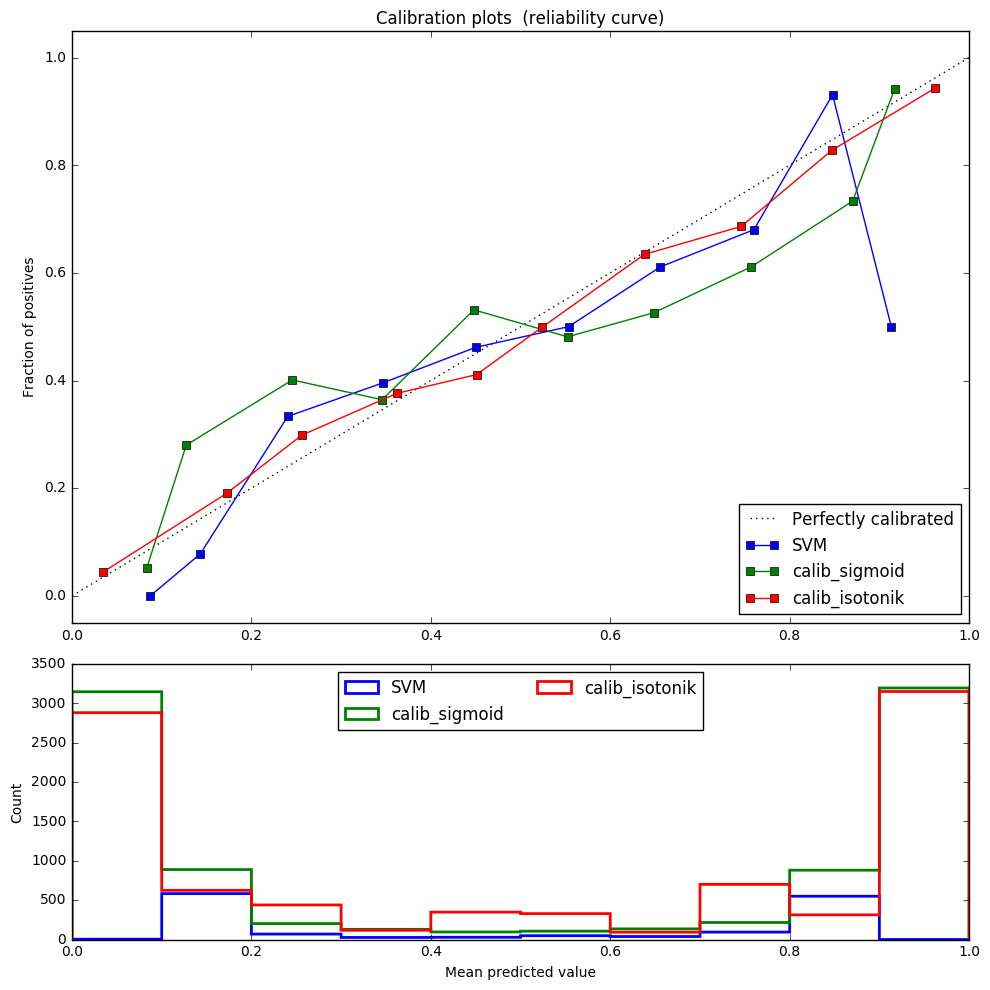

In [123]:
svm = SVC( C= 74, max_iter = 1594, kernel='linear', random_state=7,probability = True)
Xtr, Xvalm, ytr, yvalm = train_test_split(Xmeta_prob, ymeta, test_size=0.36,stratify = ymeta,random_state=7)
svm.fit(Xtr, ytr)
svmval_pred = svm.predict_proba(Xvalm)[:,1]
#svmval_pred = svm.decision_function(Xvalm)
#svmval_pred = (svmval_pred - svmval_pred.min()) / (svmval_pred.max() - svmval_pred.min())
svmval_pred_p = svm.predict_proba(Xval_prob)[:,1]
#svmval_pred_p = svm.decision_function(Xval_prob)
#svmval_pred_p = (svmval_pred_p - svmval_pred_p.min()) / (svmval_pred_p.max() - svmval_pred_p.min())
print("svm_log_loss:",log_loss(yval, svmval_pred_p))

XV = pd.DataFrame()
XV['p'] = svmval_pred

XVV = pd.DataFrame()
XVV['p'] = svmval_pred_p

cl_sigmoid = CalibratedClassifierCV(base_estimator=svm, method='sigmoid', cv=5)
cl_isotonic = CalibratedClassifierCV(base_estimator=svm, method='isotonic', cv=5)
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

fraction_of_positives, mean_predicted_value = calibration_curve(yval, svmval_pred_p, n_bins=10)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % ('SVM', ))

ax2.hist(svmval_pred, range=(0, 1), bins=10, label='SVM',
             histtype="step", lw=2)

for clf, name in [(cl_sigmoid,"calib_sigmoid"),(cl_isotonic,"calib_isotonik")]:
    clf.fit(XV, yvalm)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(XVV)[:, 1]
        print(name+"log_loss:",log_loss(yval, prob_pos))
    else:  # use decision function
        prob_pos = clf.decision_function(XVV)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        print(name+"log_loss:",log_loss(yval, prob_pos))
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(yval, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

Калибровка дает ощутимый прирост качества.
SVMlog_loss: 0.44628548721>calib_sigmoid_cv5log_loss: 0.323217170383>calib_isotonik_cv5log_loss: 0.314728605189
В данном случае isotonic показала себя лучше 0.314728605189 < 0.323217170383
В данном случае калибровка по кросс валидации дала лучшие результаты на тестовой выборке
0.323217170383 < 0.35127125842
Калибровка не должна сильно переупорядочивать степени уверенности принадлежности к классу, а именно на этом строится метрика AUC. 